<a href="https://colab.research.google.com/github/francoishcm/BackTesting/blob/master/Zipline_Reloaded_BacktestEngine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title
%%bash
wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
tar -xzf ta-lib-0.4.0-src.tar.gz
cd ta-lib/
./configure
make
make install

In [ ]:
#@title
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#@title
%pip install zipline-reloaded

In [ ]:
#@title
!pip install matplotlib

In [ ]:
#@title
!pip install quandl

In [ ]:
#@title
!QUANDL_API_KEY=KUnssHvVERHb5XYu9C1- zipline ingest -b 'quandl'

[2022-02-14 16:06:59.611324] INFO: zipline.data.bundles.core: Ingesting quandl.
[2022-02-14 16:06:59.611572] INFO: zipline.data.bundles.quandl: Downloading WIKI metadata.
[2022-02-14 16:07:11.133378] INFO: zipline.data.bundles.quandl: Parsing raw data.
[2022-02-14 16:07:46.999087] INFO: zipline.data.bundles.quandl: Generating asset metadata.
Merging daily equity files:  [-----------------------------------#]  1731/usr/local/lib/python3.7/dist-packages/zipline/data/bcolz_daily_bars.py:366: UserWarning: Ignoring 1 values because they are out of bounds for uint32:             open  ...  split_ratio
2011-04-11  1.79  ...          1.0

[1 rows x 7 columns]
  winsorise_uint32(raw_data, invalid_data_behavior, "volume", *OHLC)
Merging daily equity files:  [####################################]      
[2022-02-14 16:10:07.533607] INFO: zipline.data.bundles.quandl: Parsing split data.
[2022-02-14 16:10:07.675144] INFO: zipline.data.bundles.quandl: Parsing dividend data.
[2022-02-14 16:10:09.18357

In [11]:
#@title
!zipline bundles

csvdir <no ingestions>
custom-bundle 2022-02-16 20:59:54.195411
custom-bundle 2022-02-16 20:55:50.000284
custom-bundle 2022-02-16 20:55:25.902507
custom-bundle 2022-02-16 20:54:49.516235
custom-bundle 2022-02-16 20:54:19.629518
quandl 2022-02-16 15:32:25.435154
quantopian-quandl <no ingestions>


In [ ]:
!pip install stockstats

In [ ]:
#@title
!pip install git+https://github.com/quantopian/pyfolio


# **SAVE PERFORMANCE RESULTS TO CSV**

In [ ]:
perf.portfolio_value.to_csv('model_performance.csv')

# **CLENOW CORE TREND MODEL CODE**

In [10]:
#@title
%matplotlib inline

import zipline
from zipline import run_algorithm
from zipline.api import order_target_percent, symbol, set_commission, set_slippage, schedule_function, date_rules, time_rules
from datetime import date, datetime
import pytz
import matplotlib.pyplot as plt 
import pyfolio as pf
import pandas as pd 
import numpy as np 
from scipy import stats
from zipline.finance.commission import PerDollar
from zipline.finance.slippage import VolumeShareSlippage, FixedSlippage

#Model Settings

intial_portfolio = 100000
momentum_window = 125
minimum_momentum = 40
portfolio_size = 30
vola_window = 20

#Commission and Slippage Settings

enable_commission = True 
commission_pct = 0.001 
enable_slippage = True 
slippage_volume_limit = 0.025
slippage_impact = 0.05

def momentum_score(ts):

  #Input: Price time series.Output: Annualized exponential regression slope, multiplied by the R2

  # Make a list of consecutive numbers 
  x = np.arange(len(ts))
  # Get logs
  log_ts = np.log(ts)
  # Calculate regression values
  slope, intercept, r_value, p_value, std_err = stats.linregress(x, log_ts) 
  # Annualize percent
  annualized_slope = (np.power(np.exp(slope), 252) - 1) * 100 
  #Adjust for fitness
  score = annualized_slope * (r_value ** 2) 
  return score

def volatility(ts):
  return ts.pct_change().rolling(vola_window).std().iloc[-1]

def output_progress(context):

  #Output some performance numbers during backtest run 
  #This code just prints out the past month's performance,
  # so that we have something to look at while the backtest runs.

  # Get today's date
  today = zipline.api.get_datetime().date()

  # Calculate percent difference since last month
  perf_pct = (context.portfolio.portfolio_value / context.last_month) - 1

  # Print performance, format as percent with two decimals. 
  print("{} - Last Month Result: {:.2%}".format(today, perf_pct))

  # Remember today's portfolio value for next month's calculation 
  context.last_month = context.portfolio.portfolio_value

#Initialization and trading logic


def initialize(context):

  # Set commission and slippage.
  if enable_commission:
    comm_model = PerDollar(cost=commission_pct) 
  else:
    comm_model = PerDollar(cost=0.0) 
  set_commission(comm_model)
  if enable_slippage: slippage_model=VolumeShareSlippage(volume_limit=slippage_volume_limit,
price_impact=slippage_impact) 
  else:
    slippage_model=FixedSlippage(spread=0.0) 
  set_slippage(slippage_model)

  # Used only for progress output. 
  context.last_month = intial_portfolio

  # Store index membership
  context.index_members = pd.read_csv('/content/drive/MyDrive/index_members/sp500.csv', index_col=0, parse_dates=[0])


  #Schedule rebalance monthly. 
  schedule_function(
    func=rebalance, 
    date_rule=date_rules.month_start(), 
    time_rule=time_rules.market_open()
  )

def rebalance(context, data):
  # Write some progress output during the backtest 
  output_progress(context)

  # First, get today's date
  today = zipline.api.get_datetime()

  # Second, get the index makeup for all days prior to today.
  all_prior = context.index_members.loc[context.index_members.index < today]

  # Now let's snag the first column of the last, i.e. latest, entry. 
  latest_day = all_prior.iloc[-1,0]

  # Split the text string with tickers into a list 
  list_of_tickers = latest_day.split(',')

  # Finally, get the Zipline symbols for the tickers 
  todays_universe = [symbol(ticker) for ticker in list_of_tickers]

  todays_universe = [ 
    symbol(ticker) for ticker in
    context.index_members.loc[context.index_members.index < today].iloc[-1,0].split(',')
  ]

  # Get historical data
  hist = data.history(todays_universe, "close", momentum_window, "1d")

  # Make momentum ranking table
  ranking_table = hist.apply(momentum_score).sort_values(ascending=False)

  #Sell Logic
  #First we check if any existing position should be sold.
    #Sell if stock is no longer part of index.
    #Sell if stock has too low momentum value.

  kept_positions = list(context.portfolio.positions.keys()) 
  for security in context.portfolio.positions:
    if (security not in todays_universe): 
      order_target_percent(security, 0.0) 
      kept_positions.remove(security)
    elif ranking_table[security] < minimum_momentum: 
      order_target_percent(security, 0.0) 
      kept_positions.remove(security)

  #Stock Selection Logic
  #Check how many stocks we are keeping from last month.
  #Fill from top of ranking list, until we reach the desired total number of portfolio holdings.

  replacement_stocks = portfolio_size - len(kept_positions) 
  buy_list = ranking_table.loc[
    ~ranking_table.index.isin(kept_positions)][:replacement_stocks]
  new_portfolio = pd.concat(
    (buy_list,
    ranking_table.loc[ranking_table.index.isin(kept_positions)])
  )
  buy_list = ranking_table.loc[
    ~ranking_table.index.isin(kept_positions)][:replacement_stocks]

  #Calculate inverse volatility for stocks, and make target position weights.

  vola_table = hist[new_portfolio.index].apply(volatility) 
  inv_vola_table = 1 / vola_table
  sum_inv_vola = np.sum(inv_vola_table) 
  vola_target_weights = inv_vola_table / sum_inv_vola
  for security, rank in new_portfolio.iteritems(): 
    weight = vola_target_weights[security]
    if security in kept_positions:
      order_target_percent(security, weight)
    else:
      if ranking_table[security] > minimum_momentum: 
        order_target_percent(security, weight)

def analyze(context, perf):
  perf['max'] = perf.portfolio_value.cummax() 
  perf['dd'] = (perf.portfolio_value / perf['max']) - 1 
  maxdd = perf['dd'].min()

  ann_ret = (np.power((perf.portfolio_value.iloc[-1] / perf.portfolio_value.iloc[0]),(252 / len(perf)))) - 1

  print("Annualized Return: {:.2%} Max Drawdown: {:.2%}".format(ann_ret, maxdd))

  return


start = pd.to_datetime('2000-1-1', utc=True)
end = pd.to_datetime('2018-1-1', utc=True)

results = run_algorithm(
    start=start,
    end=end, 
    initialize=initialize, 
    analyze=analyze, 
    capital_base=intial_portfolio, 
    data_frequency = 'daily', 
    bundle='custom-bundle')

ValueError: ignored

# **WRITE BACK TEST CODE HERE**

HTML(value='')

Start date,1993-01-04
End date,2017-12-29
Total months,299
,Backtest
Annual return,5.043%
Cumulative returns,241.832%
Annual volatility,20.247%
Sharpe ratio,0.34
Calmar ratio,0.08
Stability,0.26
Max drawdown,-65.91%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,65.91,1999-07-13,2006-09-11,NaT,NaN
1,25.23,1997-01-21,1997-04-10,1997-05-27,91
2,22.11,1996-02-27,1996-06-14,1996-11-06,182
3,20.16,1995-08-17,1995-10-10,1996-02-23,137
4,17.38,1999-01-21,1999-02-09,1999-04-23,67


Stress Events,mean,min,max
Dotcom,-0.02%,-4.71%,7.65%
Lehman,-0.33%,-4.13%,2.51%
9/11,0.00%,0.00%,0.00%
US downgrade/European Debt Crisis,-0.33%,-4.74%,2.85%
Fukushima,0.20%,-3.79%,1.34%
US Housing,-0.48%,-5.53%,3.34%
EZB IR Event,0.14%,-1.04%,1.46%
Aug07,0.24%,-2.00%,2.30%
Mar08,0.12%,-2.49%,2.48%
Sept08,-0.43%,-4.13%,2.51%


Top 10 long positions of all time,max
sid,
IBM,107.39%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
IBM,107.39%


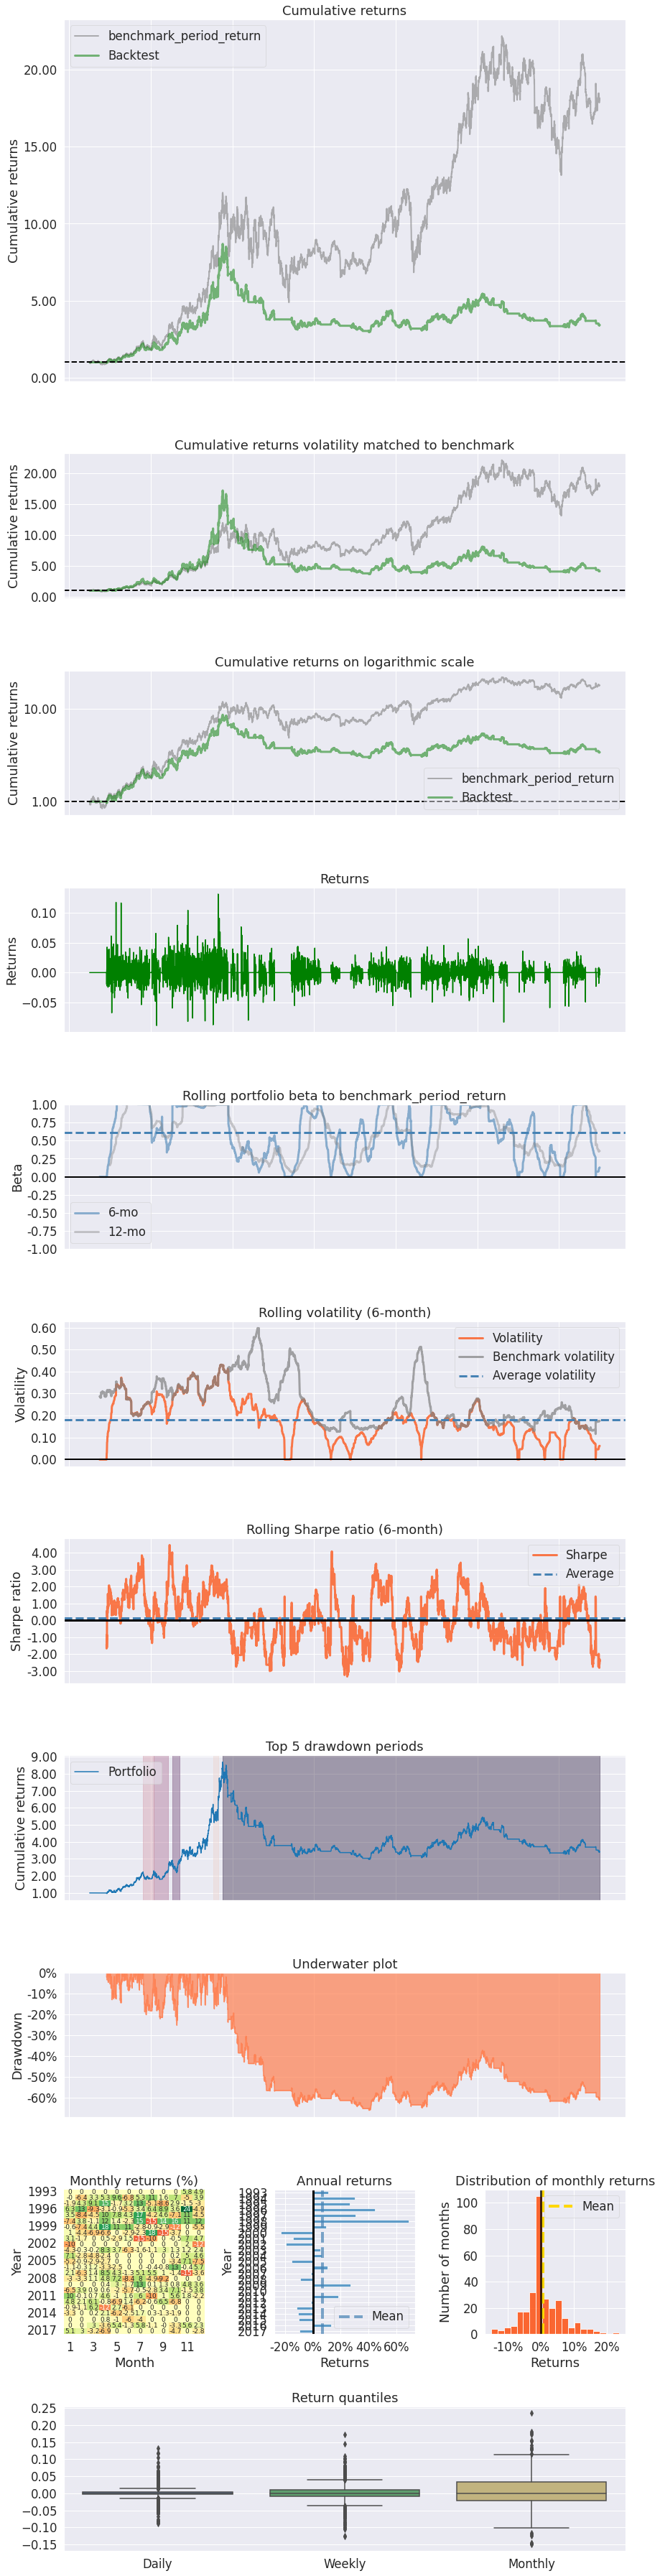

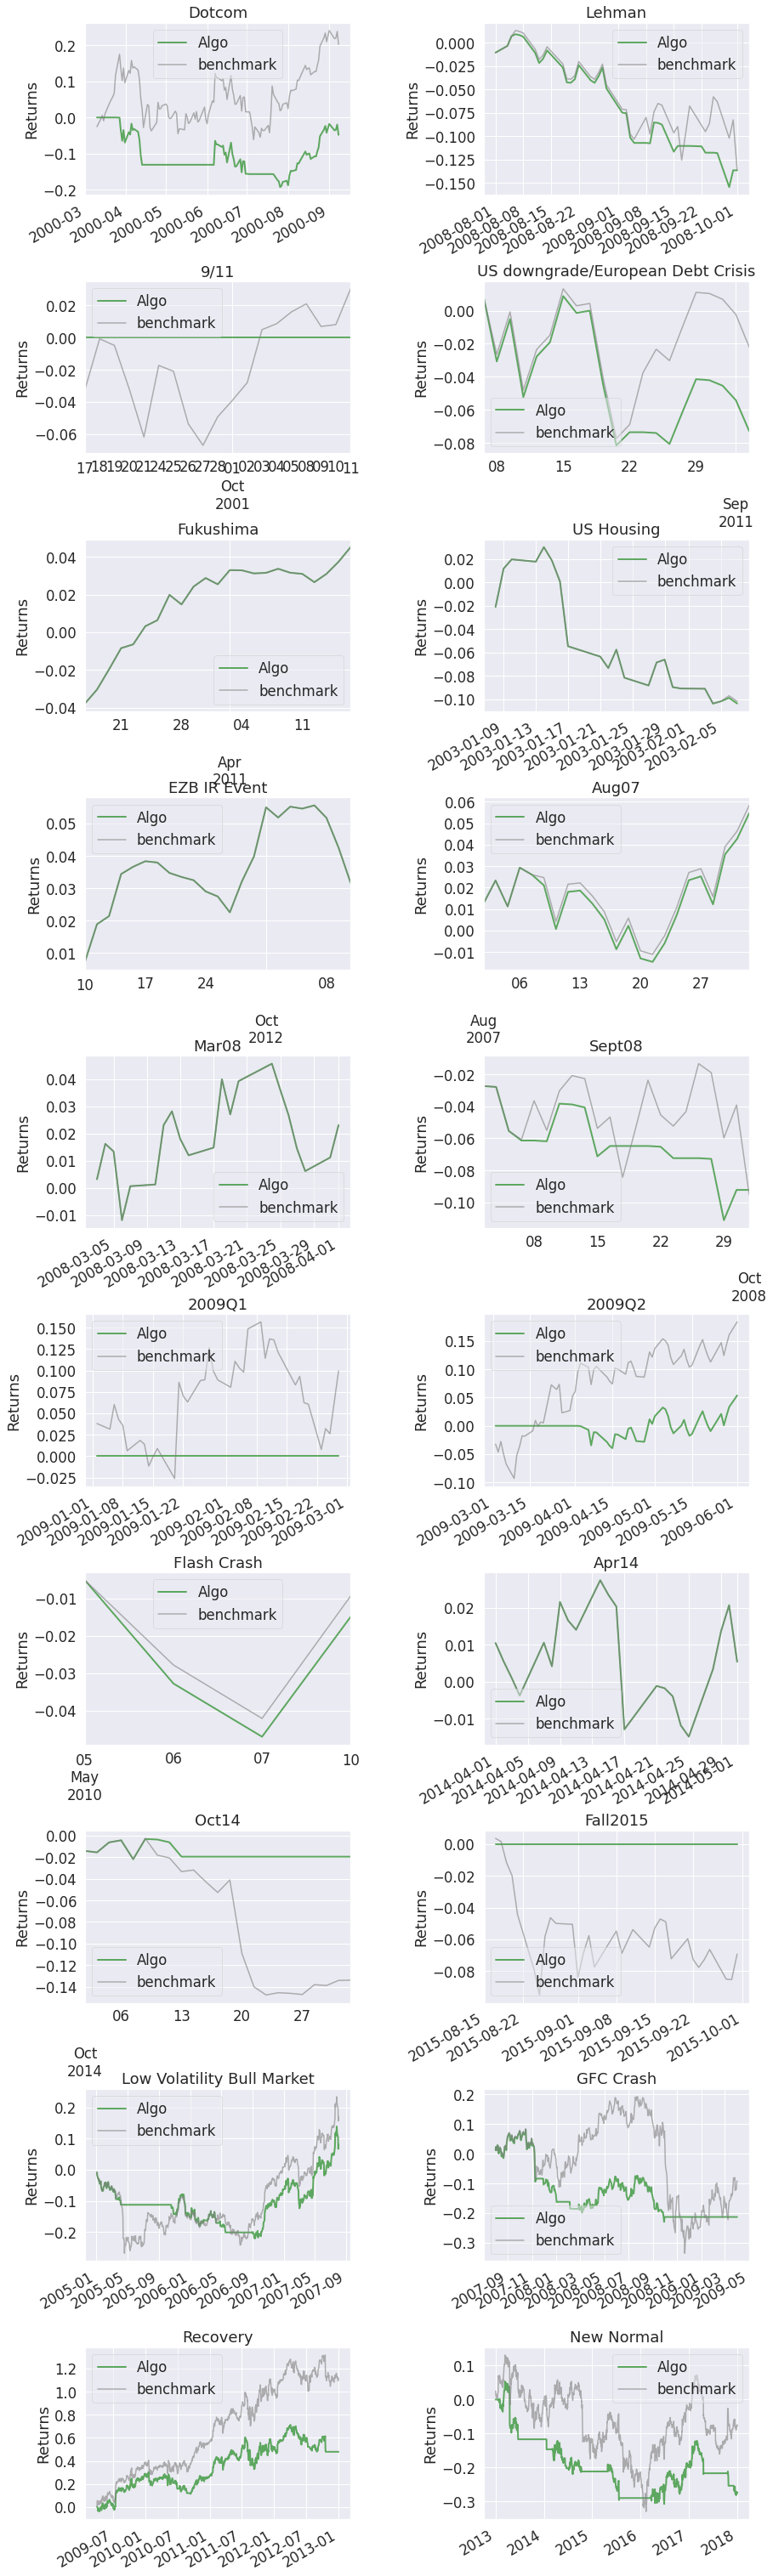

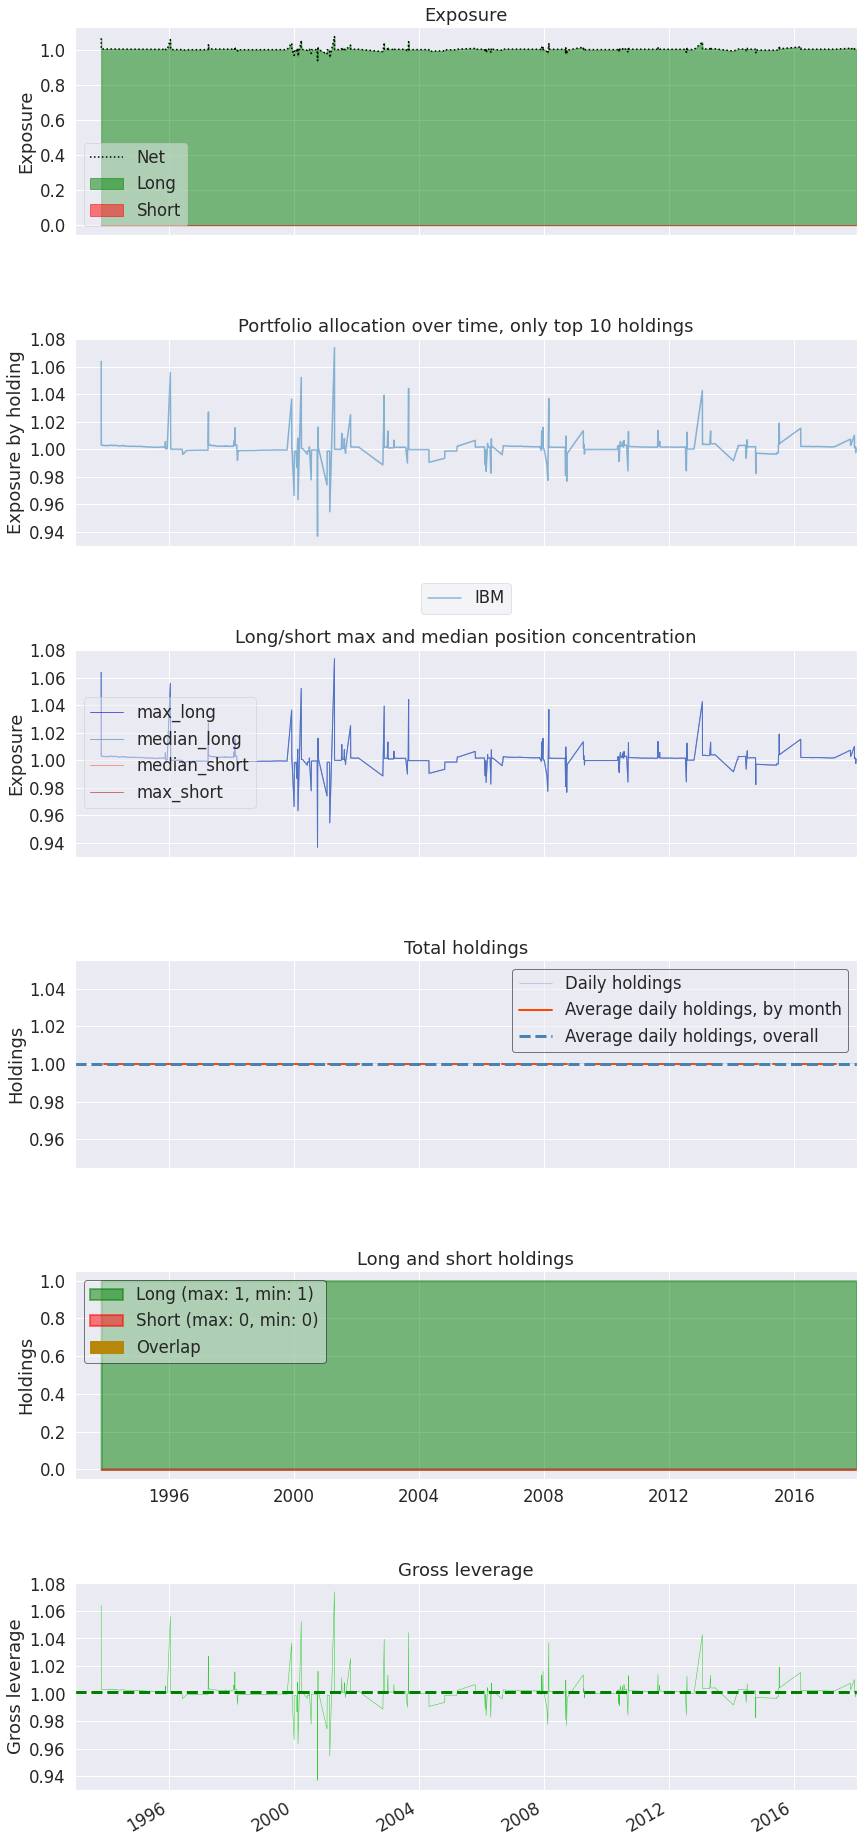

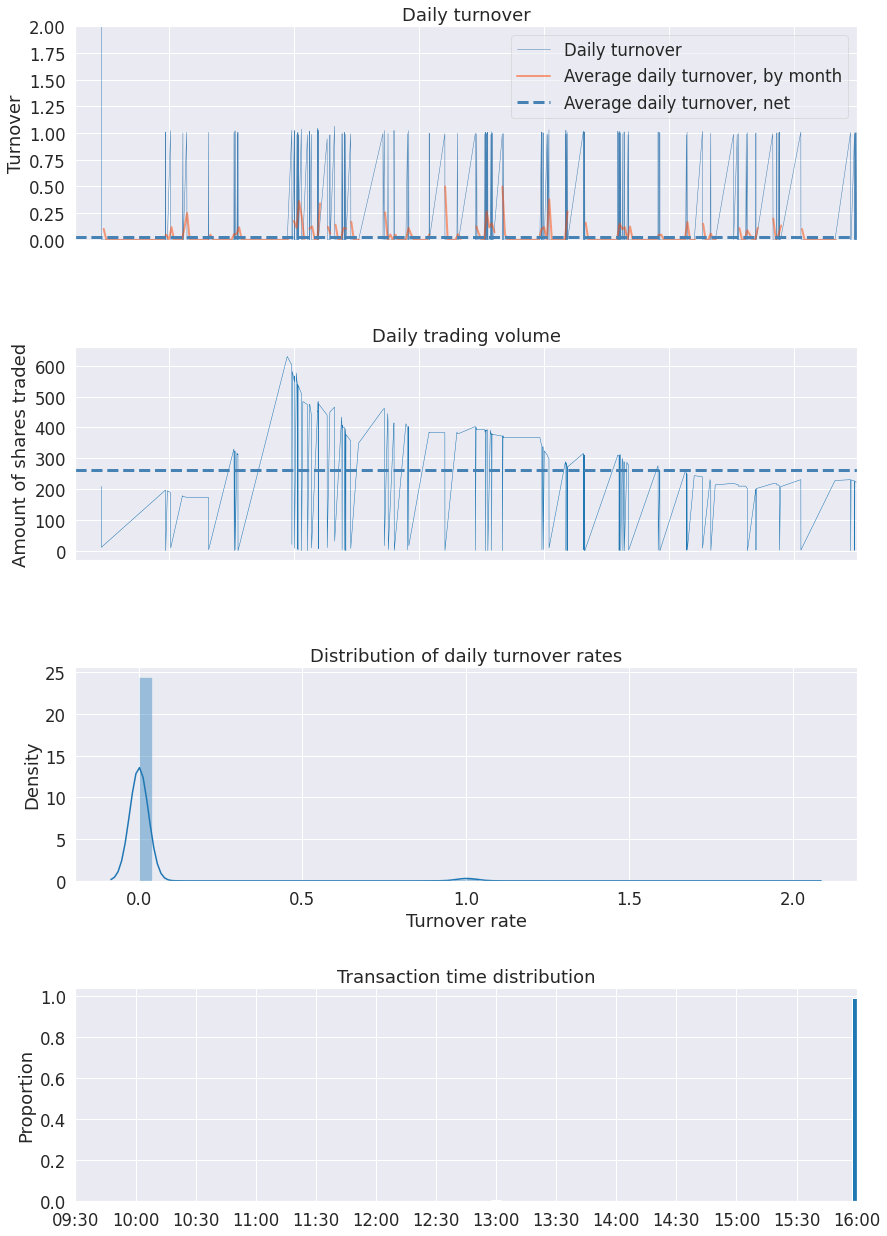

In [ ]:
#@title
%matplotlib inline

from zipline import run_algorithm
from zipline.api import order_target_percent, symbol, record, set_benchmark, set_commission
from zipline.finance.commission import PerTrade
from datetime import datetime
import pytz
import pandas as pd
import pyfolio as pf
import numpy as np
from stockstats import StockDataFrame as sdf
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
import ipywidgets as widgets
out = widgets.HTML()
display(out)

def report_result(context, data):
  context.months += 1
  today = zipline.api.get_datetime().date()
  # Calculate annualized return so far
  ann_ret = np.power(context.portfolio.portfolio_value / starting_portfolio, 12 / context.months) - 1
  # Update the text
  out.value = """{} We have traded <b>{}</b> months and the annualized return is <b>{:.2%}</b>""".format(today, context.months, ann_ret)

def initialize(context):
  context.stock = symbol('IBM')
  context.rolling_window = 200
  set_benchmark(symbol('IBM'))

def handle_data(context, data):
  
  price_hist = data.history(context.stock, "close", context.rolling_window, "1d")
  
  order_target_percent(context.stock, 1.0 if price_hist[-1] > price_hist.mean() else 0.0)

def analyze(context, perf):

  # We need to be able to calulate the daily returns from the cumulative returns

  daily_returns = pd.Series([0.5, -0.5, 0.5, -0.5])
  cumulative_returns = pd.Series([0.5, -0.25, 0.125, 0.5625])

  returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
  benchmark_period_return = perf['benchmark_period_return']

  # Convert benchmark returns to daily returns
  #daily_returns = (1 + benchmark_period_return) / (1 + benchmark_period_return.shift()) - 1
  daily_benchmark_returns = np.exp(np.log(benchmark_period_return + 1.0).diff()) - 1

  # Create tear sheet
  pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions, benchmark_rets=daily_benchmark_returns)

start_date = pd.to_datetime('1993-1-1', utc=True)
end_date = pd.to_datetime('2018-1-1', utc=True)

results = run_algorithm(
    start = start_date, 
    end = end_date,
    initialize = initialize,
    analyze = analyze,
    handle_data = handle_data,
    capital_base = 10000,
    data_frequency = 'daily',
    bundle ='quandl')

# **CODE FOR CREATING AND CONFIRMING WORKING DIRECTORIES**

In [13]:
import os 

# Set your working directory to a folder in your Google Drive. This way, if your notebook times out,
# your files will be saved in your Google Drive!

# the base Google Drive directory
root_dir = "/content/drive/My Drive/"

# choose where you want your project files to be saved
project_folder = "Colab Notebooks/My Project Folder/"

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

  # create a test file to make sure it shows up in the right place
  !touch 'new_file_in_working_directory.txt'
  print('\nYour working directory was changed to ' + root_dir + project_folder + \
        "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

create_and_set_working_directory(project_folder)


Your working directory was changed to /content/drive/My Drive/Colab Notebooks/My Project Folder/

An empty text file was created there. You can also run !pwd to confirm the current working directory.


In [12]:
!zipline ingest -b custom-bundle

[2022-02-16 21:01:35.118736] INFO: zipline.data.bundles.core: Ingesting custom-bundle.
Traceback (most recent call last):
  File "/usr/local/bin/zipline", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.7/dist-packages/click/core.py", line 829, in __call__
    return self.main(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/click/core.py", line 782, in main
    rv = self.invoke(ctx)
  File "/usr/local/lib/python3.7/dist-packages/click/core.py", line 1259, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/usr/local/lib/python3.7/dist-packages/click/core.py", line 1066, in invoke
    return ctx.invoke(self.callback, **ctx.params)
  File "/usr/local/lib/python3.7/dist-packages/click/core.py", line 610, in invoke
    return callback(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/zipline/__main__.py", line 394, in ingest
    show_progress,
  File "/usr/local/lib/python3.7/dist-packages/zipline/data/bundles